In [49]:

SERVER_URL = 'https://staging.viresdisc.vires.services/ows'

#------------------------------------------------------------------------------

from viresclient import SwarmRequest
from viresclient._wps.time_util import parse_datetime
from numpy import arange, stack, degrees, arccos, clip, ones, concatenate
from scipy.interpolate import interp1d
from eoxmagmod import vnorm, convert, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN

SwarmRequest.COLLECTIONS.update({
    'AEJ_LPL': ['SW_OPER_AEJ{}LPL_2F'.format(x) for x in 'ABC'],
})

SwarmRequest.PRODUCT_VARIABLES.update({
    'AEJ_LPL': [
        'Latitude_QD', 'Longitude_QD', 'MLT_QD',
        'J_NE', 'J_QD',
    ],
})


def get_data(start_time, end_time=None, asynchronous=False, linear_interpolation=False):
    if end_time is None:
        end_time = start_time

    request = SwarmRequest(SERVER_URL)

    start_orbit_number = request.get_orbit_number(SPACECRAFT, parse_datetime(START_TIME))
    end_orbit_number = request.get_orbit_number(SPACECRAFT, parse_datetime(END_TIME))
    start_time, end_time =  request.get_times_for_orbits(SPACECRAFT, start_orbit_number, end_orbit_number)
    print('Spacecraft:         %s' % SPACECRAFT)
    print('Orbit number range: %s-%s' % (start_orbit_number, end_orbit_number))
    print('Start time:       ', start_time)
    print('End time:         ', end_time)
                
    start_time, end_time =  request.get_times_for_orbits(SPACECRAFT, start_orbit_number, end_orbit_number)

    # retrieve latitude profiles
    request.set_collection('SW_OPER_AEJ%sLPL_2F' % SPACECRAFT)
    request.set_products(
        measurements=[],
        auxiliaries=[],
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=asynchronous,
    )
    print('Sources:\n\t%s' % '\n\t'.join(response.sources))
    aej_lpl = response.as_xarray()
    
    # retrieve spacecraft orbit
    request.set_collection('SW_OPER_MAG%s_LR_1B' % SPACECRAFT)
    request.set_products(
        measurements=[],
        auxiliaries=[],
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=asynchronous,
    )
    print('Sources:\n\t%s' % '\n\t'.join(response.sources))
    mag_lr = response.as_xarray()
    
    #note that the linear interpolation does not fix the antemeridian
    latitude_linear  = interp1d(
        mag_lr['Timestamp'].values.astype('int64'), mag_lr['Latitude'].values, kind='linear'
    )(aej_lpl['Timestamp'].values.astype('int64'))
    
    longitude_linear = interp1d(
        mag_lr['Timestamp'].values.astype('int64'), mag_lr['Longitude'].values, kind='linear'
    )(aej_lpl['Timestamp'].values.astype('int64'))

    off_track_angular_distance_linear = angular_distance(
        aej_lpl['Latitude'].values, aej_lpl['Longitude'].values,
        latitude_linear, longitude_linear,
    )
    
    # nearest neighbour is used as a reference
    idx = interp1d(
        mag_lr['Timestamp'].values.astype('int64'), arange(mag_lr['Timestamp'].values.size), kind='nearest'
    )(aej_lpl['Timestamp'].values.astype('int64')).astype('int')
    latitude_ref = mag_lr['Latitude'].values[idx]
    longitude_ref = mag_lr['Longitude'].values[idx]

    off_track_angular_distance = angular_distance(
        aej_lpl['Latitude'].values, aej_lpl['Longitude'].values,
        latitude_ref, longitude_ref,
    )

    return {
        'Timestamp': aej_lpl['Timestamp'].values,
        'Latitude': aej_lpl['Latitude'].values,
        'Longitude': aej_lpl['Longitude'].values,
        'RefLatitude': latitude_ref,
        'RefLongitude': longitude_ref,
        'OffTrackAngularDistance': off_track_angular_distance,
        'RefLatitudeLinInt': latitude_linear,
        'RefLongitudeLinInt': longitude_linear,
        'OffTrackAngularDistanceLinInt': off_track_angular_distance_linear,
    }


def angular_distance(lat0, lon0, lat1, lon1):
    sph_coord0 = stack((lat0, lon0, ones(lat0.shape)), axis=-1)
    sph_coord1 = stack((lat1, lon1, ones(lat1.shape)), axis=-1)
    crt_coords0 = convert(sph_coord0, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN)
    crt_coords1 = convert(sph_coord1, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN)
    return degrees(arccos(clip(
        (crt_coords0 * crt_coords1).sum(axis=-1)
        / (vnorm(crt_coords0) * vnorm(crt_coords1)),
        -1.0, +1.0
    )))   

      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.216MB)

Spacecraft:         A
Orbit number range: 8850-8897
Start time:        2015-06-22 22:31:47.167352
End time:          2015-06-26 01:28:09.390139
Sources:
	SW_OPER_AEJALPL_2F_20150622T000000_20150622T235959_0101
	SW_OPER_AEJALPL_2F_20150623T000000_20150623T235959_0101
	SW_OPER_AEJALPL_2F_20150624T000000_20150624T235959_0101
	SW_OPER_AEJALPL_2F_20150625T000000_20150625T235959_0101
	SW_OPER_AEJALPL_2F_20150626T000000_20150626T235959_0101



      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (8.91MB)


Sources:
	SW_OPER_MAGA_LR_1B_20150622T000000_20150622T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150623T000000_20150623T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150624T000000_20150624T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150625T000000_20150625T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150626T000000_20150626T235959_0505_MDR_MAG_LR


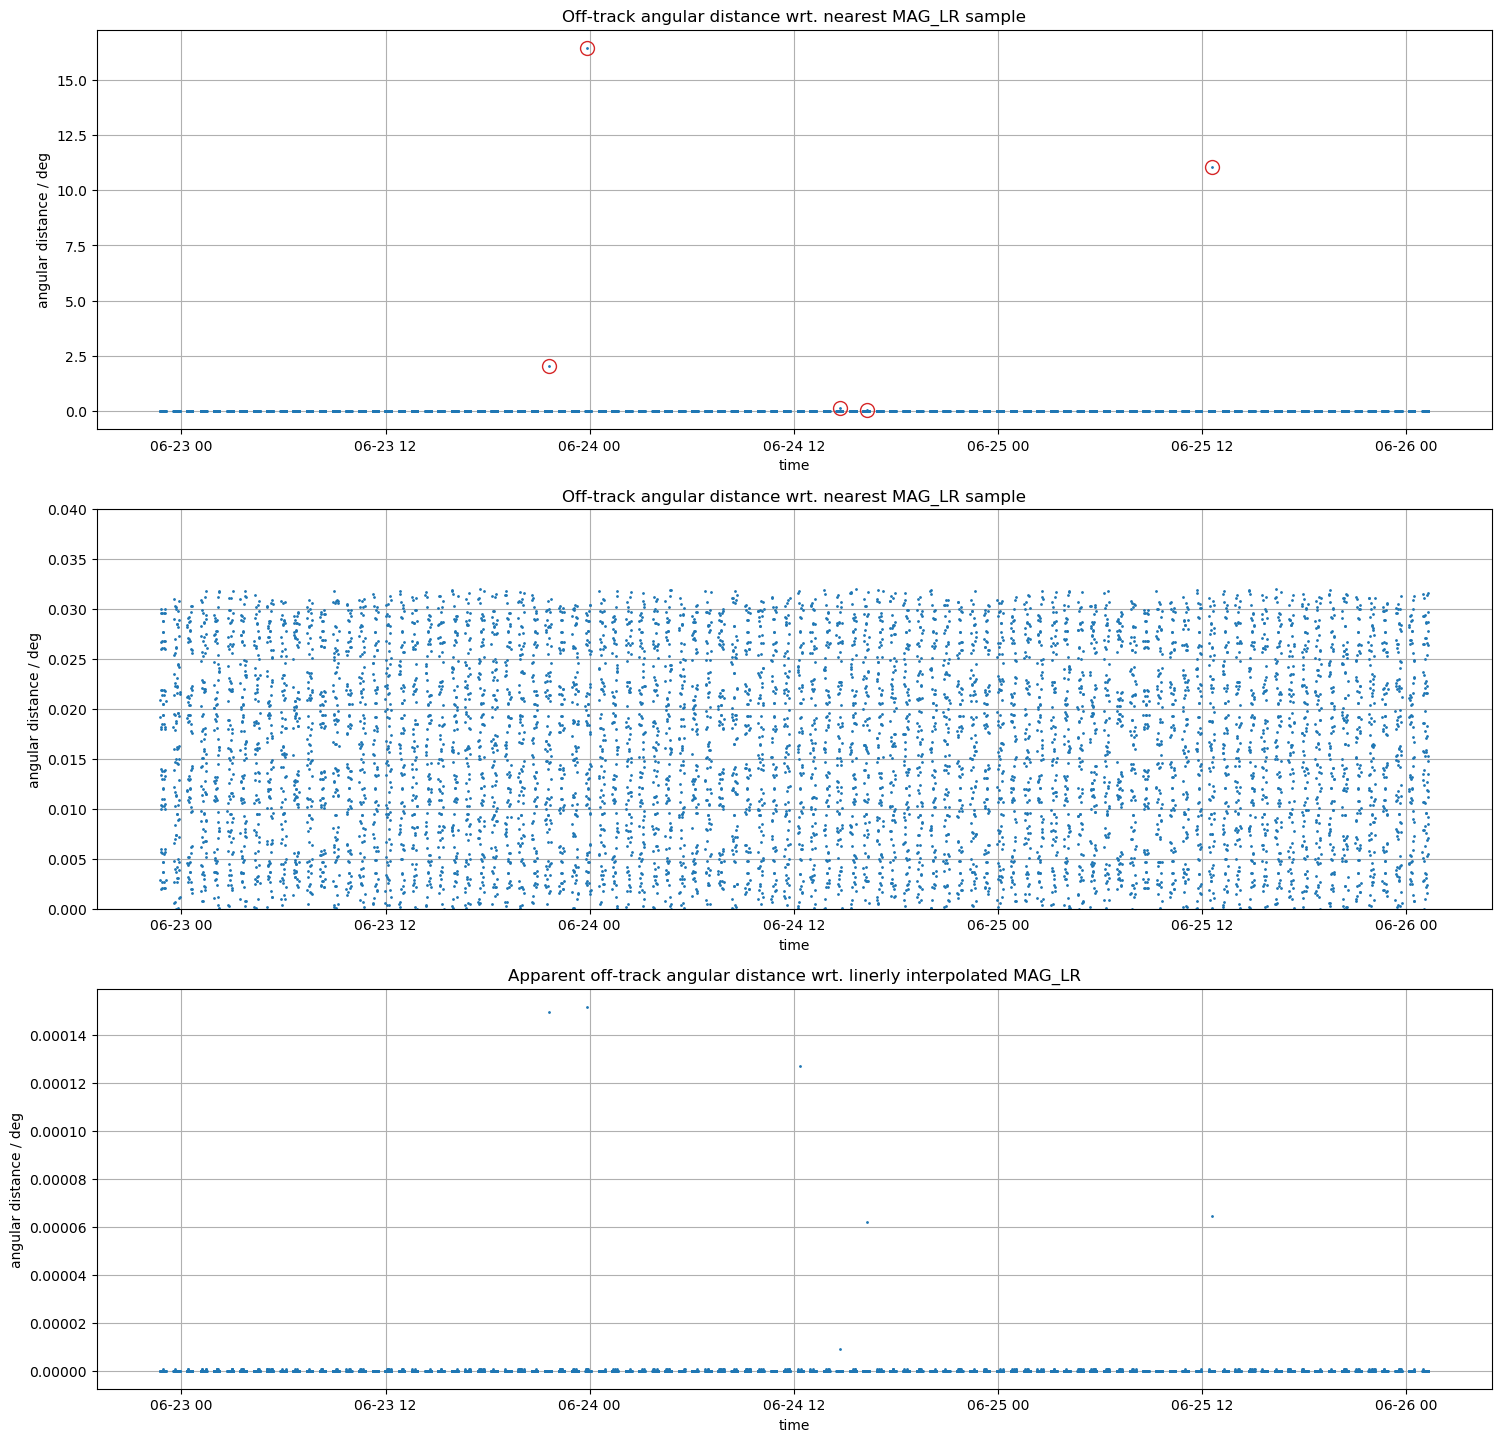

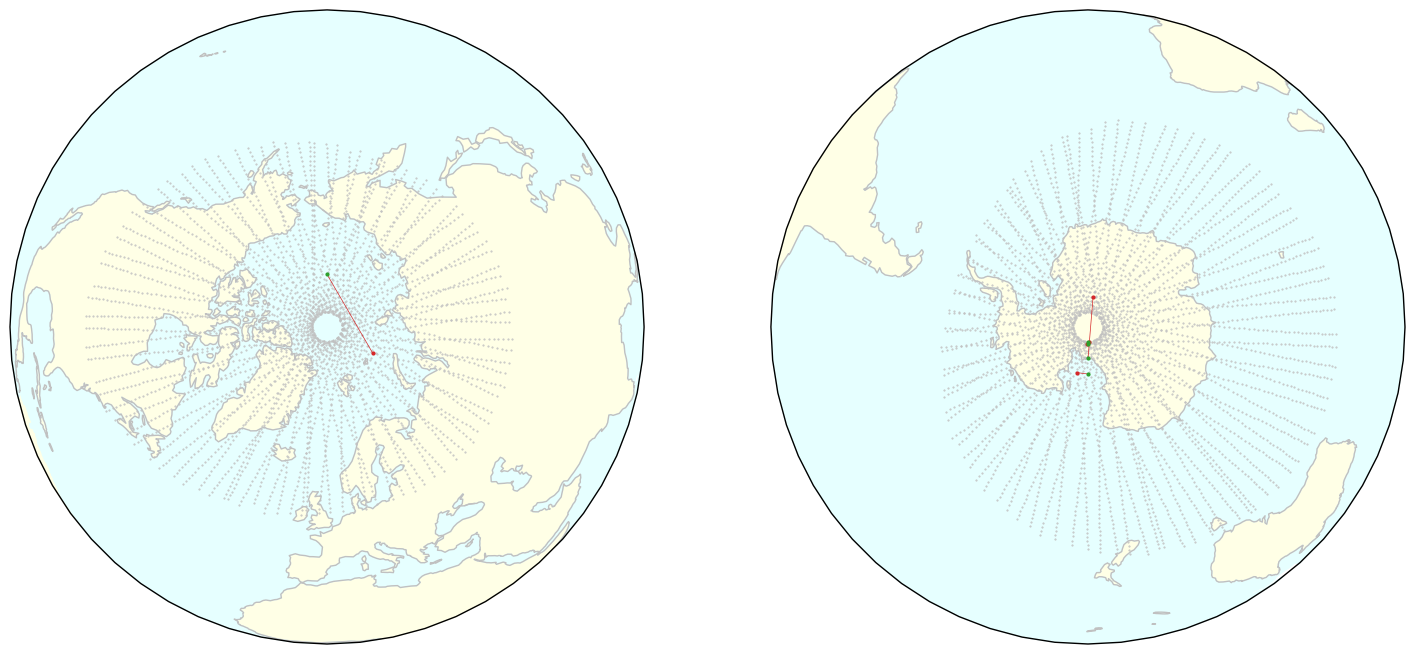

In [58]:
from numpy import stack
from matplotlib.pyplot import figure, subplot
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, Orthographic, PlateCarree


SPACECRAFT = 'A'
START_TIME = '2015-06-23T00:00:00Z'
END_TIME = '2015-06-26T00:00:00Z'
ASYNCHRONOUS = False

THRESHOLD = 0.04 # deg

data = get_data(START_TIME, END_TIME, ASYNCHRONOUS, linear_interpolation=False)
outlier_mask = data['OffTrackAngularDistance'] > THRESHOLD


def plot_time(ax):
    ax.plot(data['Timestamp'], data['OffTrackAngularDistance'], '.', ms=2.0, color='tab:blue')
    ax.plot(data['Timestamp'][outlier_mask], data['OffTrackAngularDistance'][outlier_mask], 'o', mec='tab:red', mfc='none', ms=10.0, )
    ax.set_xlabel('time')
    ax.set_ylabel('angular distance / deg')
    ax.grid()
    return ax

fig = figure(figsize=(18, 18), dpi=100)
ax = plot_time(subplot(3, 1, 1))
ax.set_title('Off-track angular distance wrt. nearest MAG_LR sample')
ax = plot_time(subplot(3, 1, 2))
ax.set_title('Off-track angular distance wrt. nearest MAG_LR sample')
ax.set_ylim(0, THRESHOLD)

ax = subplot(3, 1, 3)
ax.set_title('Apparent off-track angular distance wrt. linerly interpolated MAG_LR')
ax.plot(data['Timestamp'], data['OffTrackAngularDistanceLinInt'], '.', ms=2.0, color='tab:blue')
ax.set_xlabel('time')
ax.set_ylabel('angular distance / deg')
ax.grid()


def plot_maps(ax, north):
    h = 1 if north else -1
    gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=0, color='silver', alpha=0.5, linestyle='--')
    ax.set_xlim([-6378073.21863, 6378073.21863])
    ax.set_ylim([-6378073.21863, 6378073.21863])
    ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
    ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
    ax.add_feature(COASTLINE, edgecolor='silver')
    ax.plot(data['Longitude'], data['Latitude'], '.', c='silver', ms=1, transform=PlateCarree())
    xyz = ax.projection.transform_points(
        PlateCarree(),
        stack((data['RefLongitude'][outlier_mask], data['Longitude'][outlier_mask]), axis=-1).transpose(),
        stack((data['RefLatitude'][outlier_mask], data['Latitude'][outlier_mask]), axis=-1).transpose()
    )
    ax.plot(xyz[...,0], xyz[...,1], '-', c='tab:red', lw=0.5)
    ax.plot(data['Longitude'][outlier_mask], data['Latitude'][outlier_mask], '.', c='tab:red', ms=4, transform=PlateCarree())
    ax.plot(data['RefLongitude'][outlier_mask], data['RefLatitude'][outlier_mask], '.', c='tab:green', ms=4, transform=PlateCarree())
    
fig = figure(figsize=(18, 9), dpi=100)
plot_maps(subplot(1, 2, 1, projection=Orthographic(0, 90)), north=True)
plot_maps(subplot(1, 2, 2, projection=Orthographic(0, -90)), north=False)
